In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

loan_df = pd.read_csv('Data/Loan_Default.csv')
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [2]:
loan_df["income"] = loan_df["income"].fillna(loan_df["income"].mean())
loan_df["loan_amount"] = loan_df["loan_amount"].fillna(loan_df["loan_amount"].mean())
loan_df["rate_of_interest"] = loan_df["rate_of_interest"].fillna(loan_df["rate_of_interest"].mean())
loan_df["approv_in_adv"] = loan_df["approv_in_adv"].fillna(loan_df["approv_in_adv"].mode())



prep_loan_df = loan_df.assign(
    total_units = loan_df["total_units"].map({
        "1U": "1U",
        "2U": "2U+",
        "3U": "2U+",
        "4U": "2U+"}),
    loan_amt_v_income = loan_df["loan_amount"]/loan_df["income"]
).drop([
    'year',
    'ID',
    'open_credit',
    'construction_type',
    'Security_Type',
    'Secured_by'
], axis=1)

prep_loan_df.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Status,dtir1,loan_amt_v_income
0,cf,Sex Not Available,nopre,type1,p1,l1,nob/c,116500,4.045476,NaN,...,EXP,758,CIB,25-34,to_inst,98.728814,south,1,45.0,66.954023
1,cf,Male,nopre,type2,p1,l1,b/c,206500,4.045476,NaN,...,EQUI,552,EXP,55-64,to_inst,NaN,North,1,NaN,41.465863
2,cf,Male,pre,type1,p1,l1,nob/c,406500,4.560000,0.2000,...,EXP,834,CIB,35-44,to_inst,80.019685,south,0,46.0,42.879747
3,cf,Male,nopre,type1,p4,l1,nob/c,456500,4.250000,0.6810,...,EXP,587,CIB,45-54,not_inst,69.376900,North,0,42.0,38.425926
4,cf,Joint,pre,type1,p1,l1,nob/c,696500,4.000000,0.3042,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,0,39.0,66.714559


In [3]:
from sklearn.model_selection import train_test_split

features = [
    "loan_amount", 
    "income", 
    "Gender",
    #"rate_of_interest",
    "age",
    "lump_sum_payment",
    "credit_type",
    "total_units",
    "Credit_Worthiness",
    "Credit_Score",
    "approv_in_adv", 

]

X = pd.get_dummies(prep_loan_df[features], drop_first=True)
y = prep_loan_df["Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12345)

## Simple Ensemble Models

In [4]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=49, metric='manhattan')
knn.fit(X_train_std, y_train)

print(f"Train Accuracy: {knn.score(X_train_std, y_train)}")
print(f"Test Accuracy: {knn.score(X_test_std, y_test)}")

Train Accuracy: 0.8611690320844824
Test Accuracy: 0.8617743996771373


In [6]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.6, penalty='l1', solver='saga', max_iter=1000)
lr = logreg.fit(X_train_std, y_train)

print(f"Train Accuracy: {lr.score(X_train_std, y_train)}")
print(f"Test Accuracy: {lr.score(X_test_std, y_test)}")

Train Accuracy: 0.8607402300396853
Test Accuracy: 0.86211071500639


In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
dt.fit(X_train_std, y_train)

print(f"Train Accuracy: {round(dt.score(X_train_std, y_train), 3)}")
print(f"Test Accuracy: {round(dt.score(X_test_std, y_test), 3)}")

Train Accuracy: 0.869
Test Accuracy: 0.867


In [8]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
], voting='hard')

model.fit(X_train_std, y_train)
model.score(X_test_std, y_test)

0.8619761888746889

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=2023, max_depth=10)
rf.fit(X_train, y_train)

print(f"Train Accuracy: {rf.score(X_train, y_train)}")
print(f"Test Accuracy: {rf.score(X_test, y_test)}")

Train Accuracy: 0.867323602609807
Test Accuracy: 0.8657429205623193


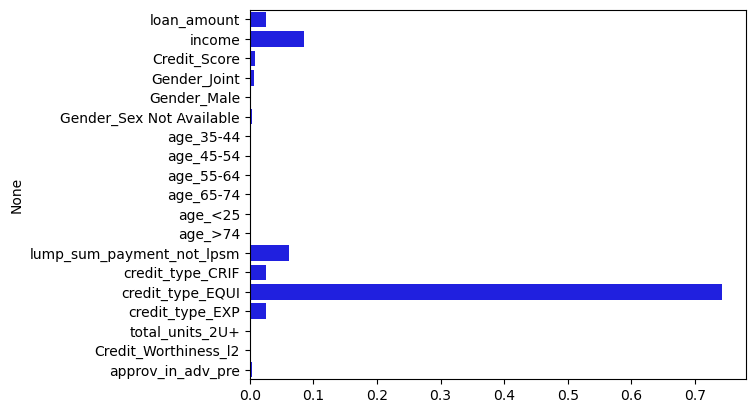

In [10]:
import seaborn as sns

sns.barplot(x=rf.feature_importances_, y=X.columns, color='blue');

In [11]:
# Random Search
from sklearn.model_selection import RandomizedSearchCV
      
rf = RandomForestClassifier(random_state=2023, n_jobs=-1)

params = {
    'n_estimators': np.arange(start=100, stop=1100, step=100),
    'max_features': [None, "sqrt"],
    'bootstrap': [True, False],
    'max_samples': [None, .3, .5, .9],
    'max_depth': np.arange(start=1, stop=11, step=1),
    'min_samples_leaf': [2, 5, 10, 20, 100],
}

grid = RandomizedSearchCV(
    rf, 
    params,
    n_iter=100,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

C:\Users\Camilo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Camilo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Camilo\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Camilo\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 433, in fit
    raise Valu

{'n_estimators': 500,
 'min_samples_leaf': 2,
 'max_samples': 0.9,
 'max_features': None,
 'max_depth': 10,
 'bootstrap': True}

In [12]:
from sklearn.model_selection import GridSearchCV
import numpy as np


rf = RandomForestClassifier(random_state=2023, n_jobs=-1)


params = {
    'n_estimators': np.arange(start=150, stop=250, step=10),
    'bootstrap': [True],
    'max_features': [None, "sqrt"],
    'max_samples': [.8, .9, .95],
    'max_depth': [9],
    'min_samples_leaf': [2, 3, 4]    
}

grid = GridSearchCV(
    rf, 
    params,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

{'bootstrap': True,
 'max_depth': 9,
 'max_features': None,
 'max_samples': 0.8,
 'min_samples_leaf': 2,
 'n_estimators': 160}

In [13]:
rf = RandomForestClassifier(random_state=2023, n_jobs=-1, **grid.best_params_)

rf.fit(X_train, y_train)

print(f"Training Accuracy: {rf.score(X_train, y_train)}")
print(f"Test Accuracy: {rf.score(X_test, y_test)}")

Training Accuracy: 0.8697030335642698
Test Accuracy: 0.8680634963341629


## Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=2023)
gbm.fit(X_train, y_train)

print(f"Train Accuracy: {gbm.score(X_train, y_train)}")
print(f"Test Accuracy: {gbm.score(X_test, y_test)}")

Train Accuracy: 0.8665921167686823
Test Accuracy: 0.8667518665500773


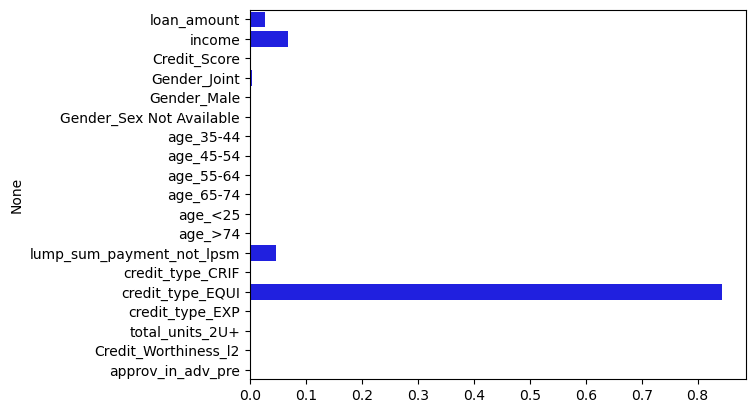

In [15]:
import seaborn as sns

sns.barplot(x=gbm.feature_importances_, y=X.columns, color='blue');

In [ ]:
import numpy as np

from sklearn.model_selection import RandomizedSearchCV
      
gb = GradientBoostingClassifier(random_state=2023)

params = {
    'n_estimators': [20, 40, 60, 80, 100, 200],
    'learning_rate': [.01, .1],
    'max_features': ["sqrt"],
    'subsample': [.8, .9, .95],
    'max_depth': np.arange(start=3, stop=12, step=2),
    'min_samples_leaf': [2, 5, 10]    
}

grid = RandomizedSearchCV(
    gb, 
    params,
    n_iter=100,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

In [ ]:
grid.score(X_train, y_train)

In [ ]:
grid.score(X_test, y_test)

In [ ]:
import numpy as np

from sklearn.model_selection import GridSearchCV
      
gb = GradientBoostingClassifier(random_state=2023)

params = {
    'n_estimators': [50, 60, 70],
    'learning_rate': [.1],
    'max_features': ["sqrt"],
    'subsample': [.8],
    'max_depth': [9],
    'min_samples_leaf': [10]    
}

grid = GridSearchCV(
    gb, 
    params,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=2023, **grid.best_params_)

gbm.fit(X_train, y_train)

print(f"Training Accuracy: {gbm.score(X_train, y_train)}")
print(f"Test Accuracy: {gbm.score(X_test, y_test)}")

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, gbm.predict(X_test))

In [ ]:
importance_df = (
    pd.DataFrame({"Feature": X_train.columns, "Importance": gbm.feature_importances_})
    .sort_values("Importance", ascending=False)
)

sns.barplot(importance_df, x="Importance", y="Feature" )